# Préparez des données pour un organisme de santé publique

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.decomposition import PCA
from scipy.stats import f_oneway

## Étape 1 : Nettoyez et filtrez des features et produits

In [ ]:
df = pd.read_csv("fr.openfoodfacts.org.products.csv", sep="\t", low_memory=False)

df.head()

Commençons par analyser un petit peu les données.

In [ ]:
df.shape

(320772, 162)

In [ ]:
df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'ph_100g', 'fruits-vegetables-nuts_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=162)

Nous allons sélectionner une variable ayant entre 50% et 80% de valeurs manquantes. Ce sera notre variable à analyser et prédire.

In [ ]:
missing_values = df.isnull().mean()

missing_values.loc[missing_values > 0.5].loc[missing_values < 0.8].sort_values()

additives_tags      0.517788
additives_fr        0.517788
cholesterol_100g    0.550802
trans-fat_100g      0.553271
calcium_100g        0.560280
vitamin-c_100g      0.560850
iron_100g           0.562113
vitamin-a_100g      0.571178
quantity            0.673229
pnns_groups_2       0.705426
pnns_groups_1       0.714710
categories_fr       0.736850
categories          0.736854
categories_tags     0.736919
main_category_fr    0.736991
main_category       0.736991
packaging_tags      0.753841
packaging           0.753844
image_url           0.763583
image_small_url     0.763583
dtype: float64

La variable "main_category" paraît parfaite. C'est une variable catégorielle et elle n'est ni trop vide ni trop remplie.

In [ ]:
target = df[["categories_fr", "url"]]

Maintenant, visualisons les données en fonction du pourcentage de valeurs manquantes.

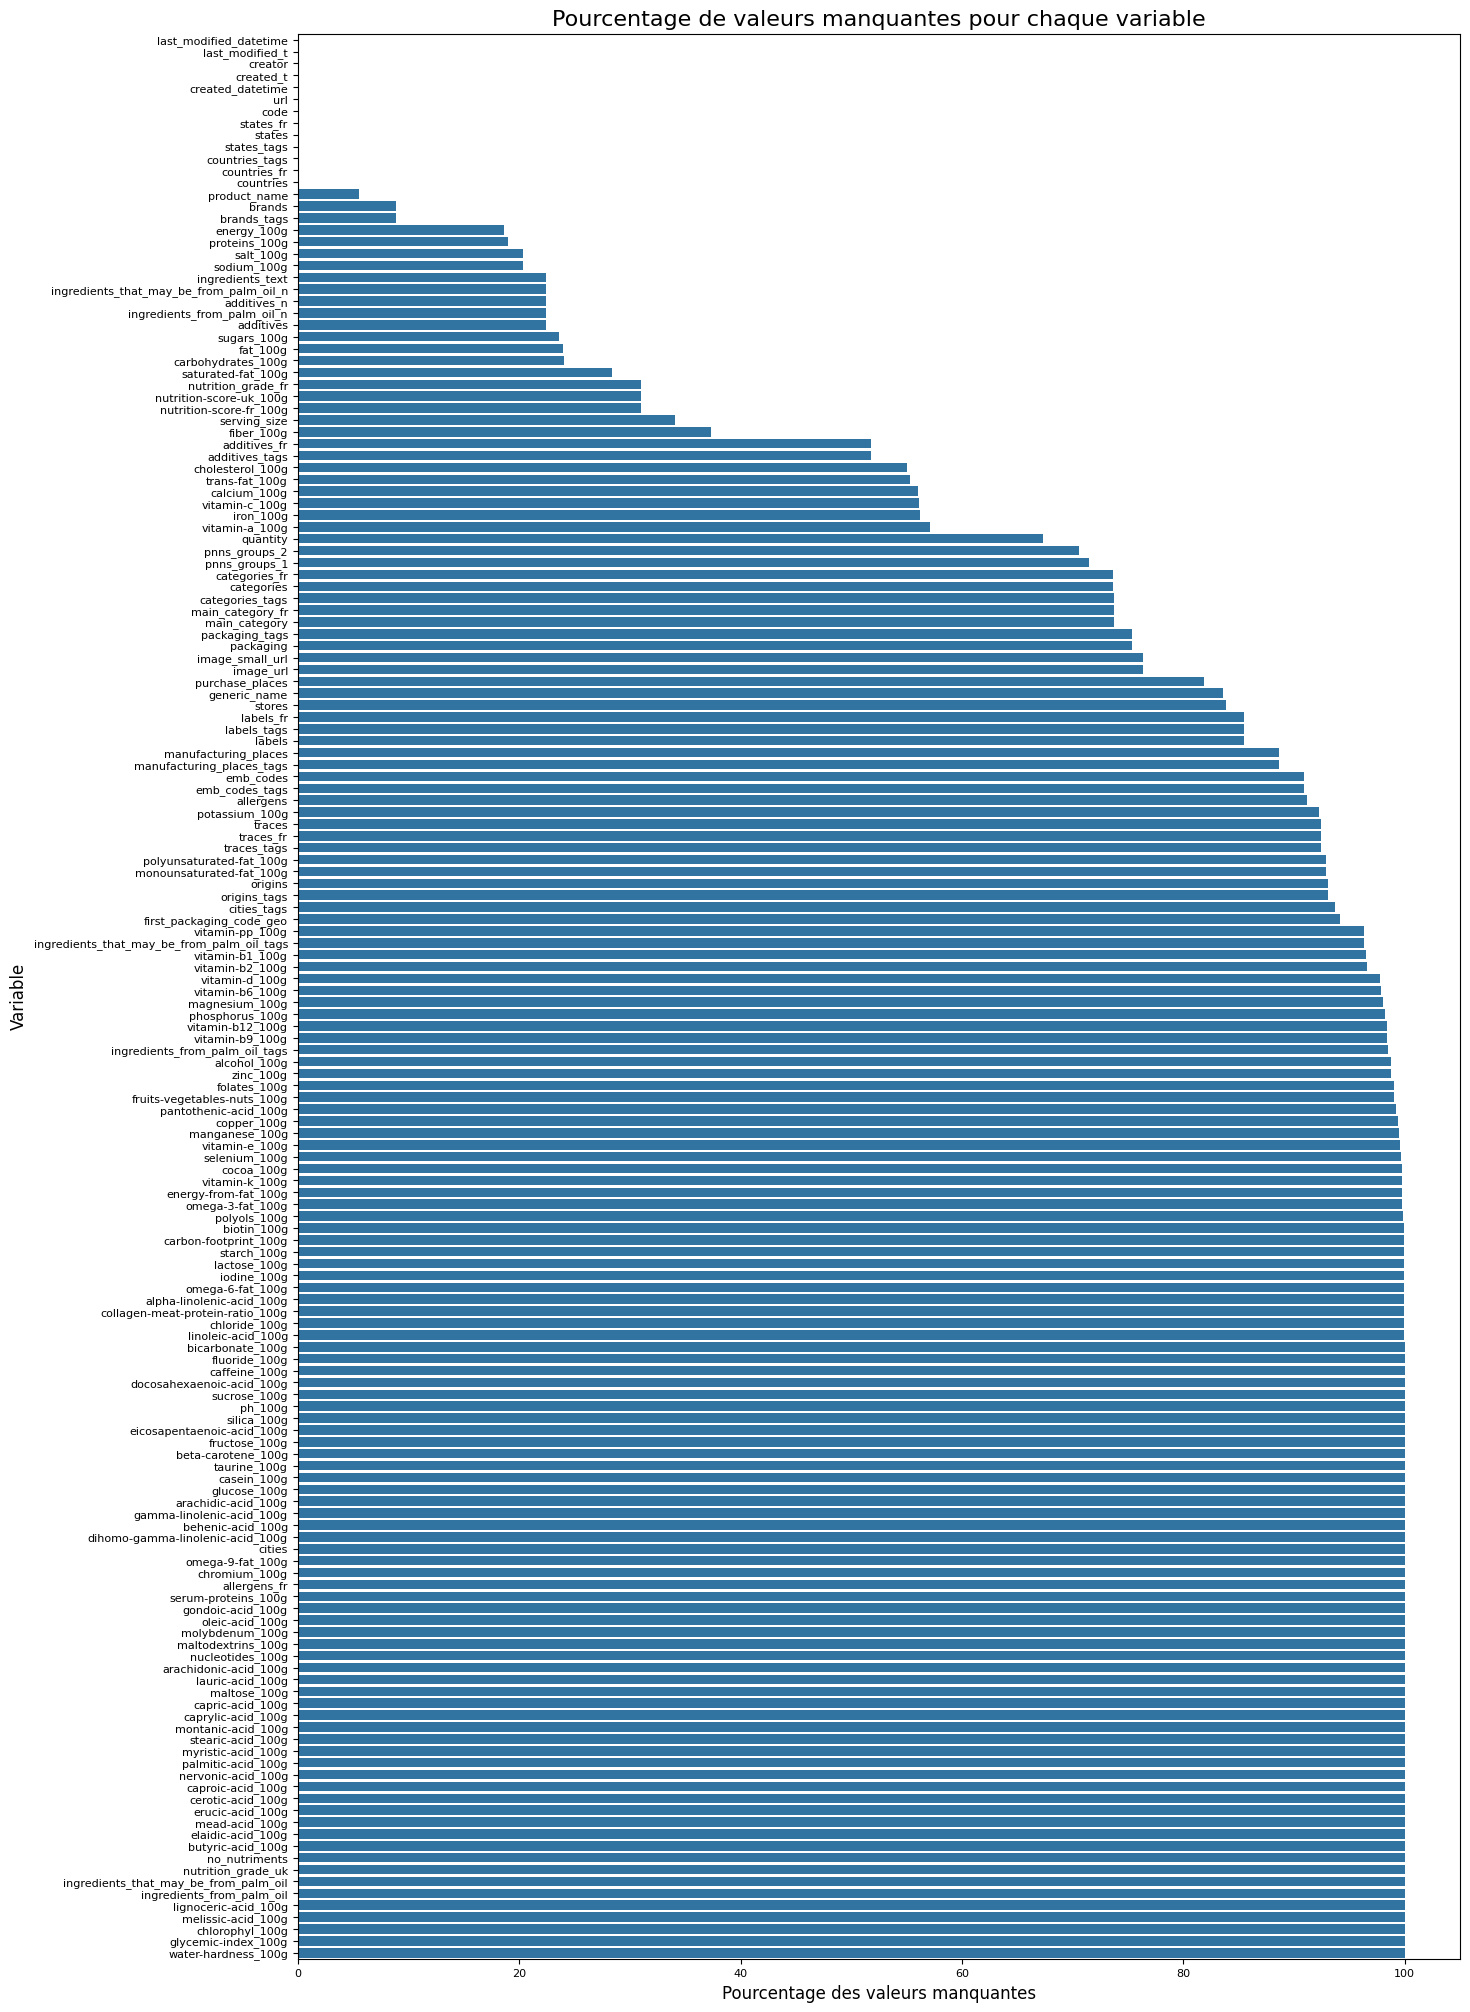

In [ ]:
proportion_of_emptiness = df.isnull().mean() * 100
proportion_of_emptiness = pd.DataFrame(proportion_of_emptiness).reset_index().sort_values(0)

fig = plt.figure(figsize=(15, 25))

plt.rcParams.update({"font.size": 8})
sns.barplot(data=proportion_of_emptiness, x=0, y="index")
plt.xlabel("Pourcentage des valeurs manquantes", fontsize=12)
plt.ylabel("Variable", fontsize=12)
plt.title("Pourcentage de valeurs manquantes pour chaque variable", fontsize=16)
plt.show()

Supprimons les variables comportant moins de 50% de taux de remplissage.

In [ ]:
df = df.loc[:, missing_values < 0.5]

Utilisons l'URL des produits pour détecter les doublons.

In [ ]:
print("Nombre de lignes dupliquées :", df["url"].duplicated().sum())
print("Nombre de lignes n'ayant pas d'url :", df["url"].isnull().sum())

Nombre de lignes dupliquées : 22
Nombre de lignes n'ayant pas d'url : 23


Il y a apparemment  23 lignes comportant des urls vide, on peut supposer que la ligne entière est vide. Regardons ces lignes plus en détails afin d'être sûr que les supprimer est la bonne approche.

In [ ]:
empty_url_row = df["url"].isnull()
df["brands"].loc[empty_url_row].unique()

array([nan], dtype=object)

Effectivement les lignes comportant des urls vides ne contiennent aucun produit. Nous pouvons les supprimer.

In [ ]:
df = df.loc[empty_url_row == False]

Nous allons maintenant faire la sélection des variables qui seront destinées à prédire la variable cible. Pour cela, nous choisissons des variables étant remplies au minimum à 50%. Il faut, bien sûr, aussi qu'elles aient un rapport avec notre variable cible afin qu'elles puissent la prédire.

In [ ]:
df = df[[
    "url",
    "nutrition_grade_fr",
    "energy_100g",
    "fat_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g",
]]

In [ ]:
def features_selection(dataframe):
    dataframe.columns
    target = dataframe["calcium_100g"]
    df.isnull().mean()
    dataframe = dataframe.loc[df["code"].duplicated() == False]
    dataframe = dataframe[[
        "url",
        "nutrition_grade_fr",
        "energy_100g",
        "fat_100g",
        "sugars_100g",
        "fiber_100g",
        "proteins_100g",
        "salt_100g",
    ]]
    return (dataframe, target)

## Étape 2 : Identifiez et traitez les valeurs aberrantes

Occupons-nous maintenant de traiter les valeurs aberrantes. Pour cela, nous allons en premier lieu utiliser des boîtes à moustaches afin de visualiser la distribution des valeurs nutritives.

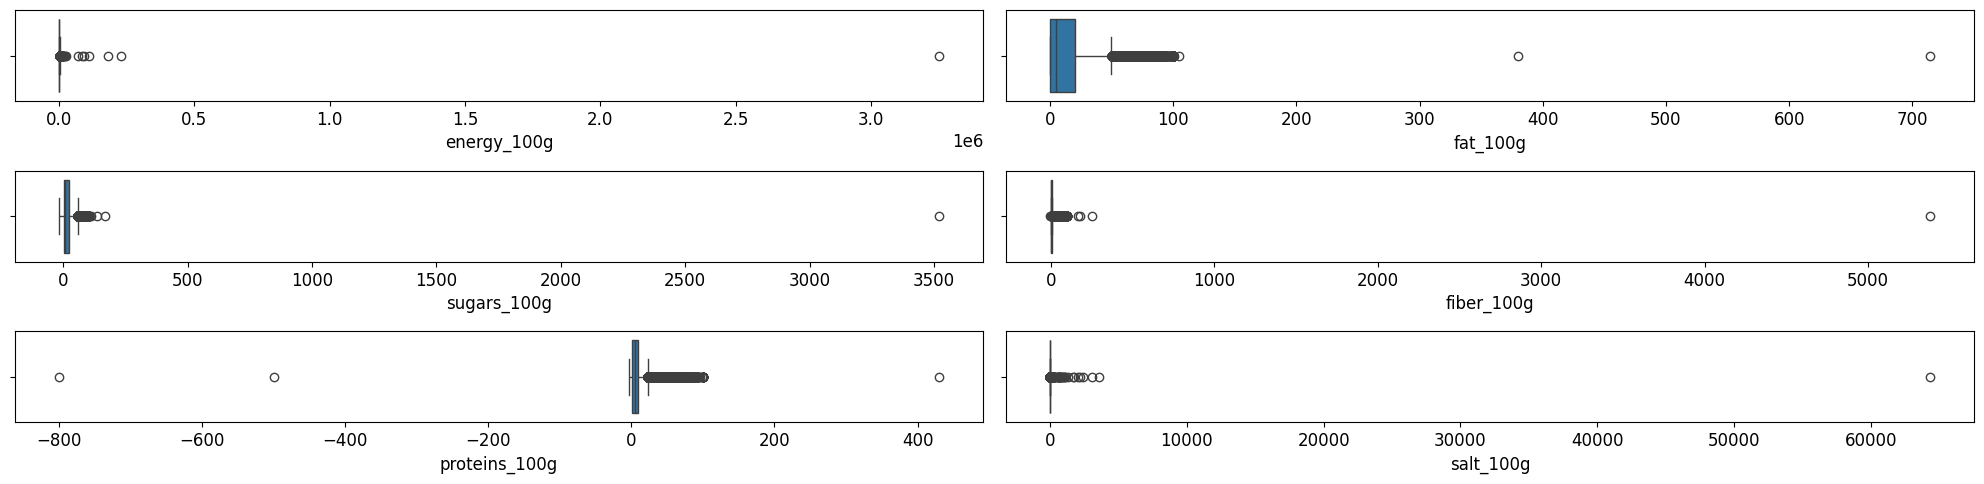

In [ ]:
nutritive_values = ["energy_100g", "fat_100g", "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g"]

plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(3, 2, figsize=(20,5))

ax = ax.flatten()
for i, value in enumerate(nutritive_values[0:len(nutritive_values)]):
    sns.boxplot(data=df, x=value, ax=ax[i])

plt.tight_layout()

On repère deux problèmes. Premièrement, certaines valeurs sont négatives, ce qui, vous en conviendrez, est impossible. Deuxièmement, des valeurs dépassent la valeur maximale possible pour ce type de données. Par exemple, le produit le plus gras contient plus de 700g de gras pour 100g de produit. C'est bien évidemment impossible. Nous allons donc supprimer les valeurs en trop, et nous allons même rechercher les aliments contenant le plus de protéines et de fibres possible, ainsi que l'aliment apportant le plus de kilos joules au corps, afin d'estimer des valeurs maximum plus précises pour ces données.

In [ ]:
df = df.loc[((df["energy_100g"] >= 0) & (df["energy_100g"] <= 3700)) | (df["energy_100g"].isna())]
df = df.loc[((df["fat_100g"] >= 0) & (df["fat_100g"] <= 100)) | (df["fat_100g"].isna())]
df = df.loc[((df["sugars_100g"] >= 0) & (df["sugars_100g"] <= 100)) | (df["sugars_100g"].isna())]
df = df.loc[((df["fiber_100g"] >= 0) & (df["fiber_100g"] <= 16)) | (df["fiber_100g"].isna())]
df = df.loc[((df["proteins_100g"] >= 0) & (df["proteins_100g"] <= 58)) | (df["proteins_100g"].isna())]
df = df.loc[((df["salt_100g"] >= 0) & (df["salt_100g"] <= 100)) | (df["salt_100g"].isna())]
df.isna().mean()

url                   0.000000
nutrition_grade_fr    0.312550
energy_100g           0.188484
fat_100g              0.241356
sugars_100g           0.238090
fiber_100g            0.377705
proteins_100g         0.192167
salt_100g             0.205867
dtype: float64

(316292, 8)


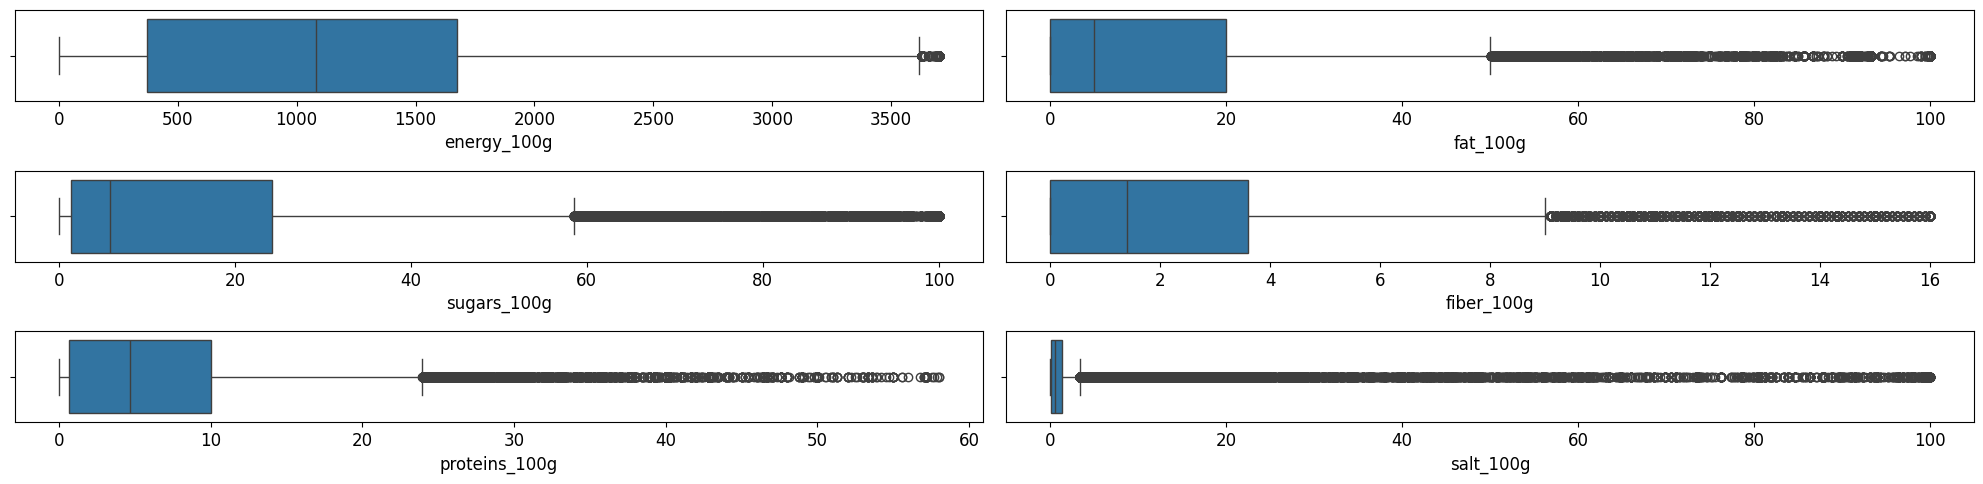

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(20,5))
ax = ax.flatten()

for i, value in enumerate(nutritive_values[0:len(nutritive_values)]):
    sns.boxplot(data=df, x=value, ax=ax[i])

plt.tight_layout()
print(df.shape)

Nous allons aussi analyser le nutriscore des produits. En premier lieu, vérifions que les seules valeurs présentes sont a, b, c, d, e. Ensuite, mettons en place un histogramme pour en apprendre davantage sur la distribution de ces valeurs.

In [ ]:
df["nutrition_grade_fr"].unique()

array([nan, 'd', 'b', 'c', 'a', 'e'], dtype=object)

<Axes: xlabel='nutrition_grade_fr', ylabel='Count'>

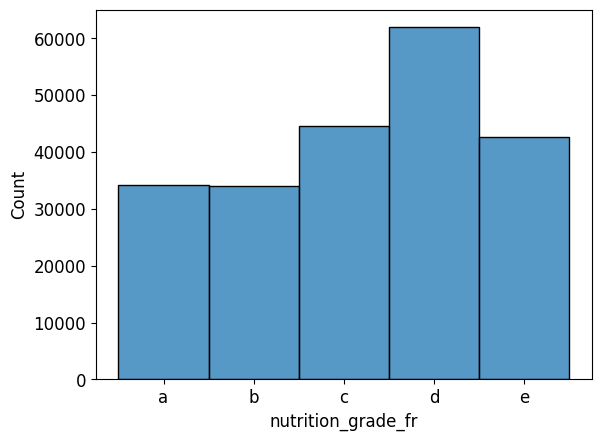

In [ ]:
df['nutrition_grade_fr'] = pd.Categorical(df['nutrition_grade_fr'], ["a","b","c","d","e"])
sns.histplot(data=df["nutrition_grade_fr"])

## Étape 3 : Identifiez et traitez les valeurs manquantes

Nous allons maintenant tenter de remplir les valeurs manquantes de notre DataFrame. Pour ceci, nous allons d'abord analyser la corrélation entre nos variables.

In [ ]:
mask = df["nutrition_grade_fr"].isnull()
nutrition_grade_encoder = LabelEncoder()
df.loc[:, "nutrition_grade_fr"] = nutrition_grade_encoder.fit_transform(df["nutrition_grade_fr"])
nutritive_values.append("nutrition_grade_fr")

df["nutrition_grade_fr"] = df["nutrition_grade_fr"].where(~mask, np.nan)

print(df.shape)
print(df.isna().mean())

(316292, 8)
url                   0.000000
nutrition_grade_fr    0.312550
energy_100g           0.188484
fat_100g              0.241356
sugars_100g           0.238090
fiber_100g            0.377705
proteins_100g         0.192167
salt_100g             0.205867
dtype: float64


/tmp/ipykernel_87508/1656369907.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[5 3 1 ... 5 5 5]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df.loc[:, "nutrition_grade_fr"] = nutrition_grade_encoder.fit_transform(df["nutrition_grade_fr"])


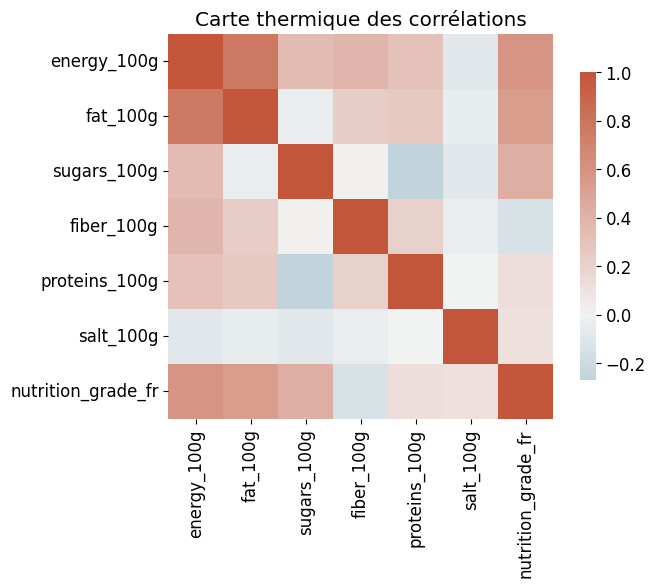

In [ ]:
f, ax = plt.subplots(figsize=(7, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df[nutritive_values].corr(), cmap=cmap, center=0, square=True, cbar_kws={"shrink": .8})
ax.set_title("Carte thermique des corrélations")

plt.show()

Nos données sont plutôt corréllées entre elles, excepté pour la variable "salt_100g". Nous allons donc utiliser l'iterative imputer pour remplir nos données manquantes, excepté pour le sel avec lequel nous utiliserons le knn imputer.

In [ ]:
nutritive_values.remove("salt_100g")

it_imp = IterativeImputer(random_state=0)
df[nutritive_values] = it_imp.fit_transform(df[nutritive_values])

/home/titouan/.local/share/virtualenvs/p3-_3AbF7j9/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
knn = KNNImputer(n_neighbors=5)
df["salt_100g"] = knn.fit_transform(pd.DataFrame(df["salt_100g"]))

In [ ]:
nutritive_values.append("salt_100g")

print(df.shape)
print(df.isna().mean())

(316292, 8)
url                   0.000000
nutrition_grade_fr    0.000000
energy_100g           0.000000
fat_100g              0.000000
sugars_100g           0.000000
fiber_100g            0.000000
proteins_100g         0.000000
salt_100g             0.205867
dtype: float64


Nous allons regarder les valeurs maximales de nos données, afin de vérifier que les valeurs imputées ne sortent pas des valeurs métier que nous avons établies.

In [ ]:
df.describe()

,nutrition_grade_fr,energy_100g,fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,316292.000000,316292.000000,316292.000000,316292.000000,316292.000000,316292.000000,251178.000000
mean,2.178981,1114.698970,12.596482,15.652077,2.220607,6.882447,1.585623
std,1.197229,713.056141,15.393012,18.832600,2.533427,6.927091,6.252405
min,-1.426186,0.000000,-38.683606,-96.615971,-3.459366,-16.058894,0.000000
25%,1.153933,494.000000,0.590000,2.350000,0.267256,1.590000,0.063500
50%,2.178981,1114.698970,11.000000,10.772522,2.104223,6.754980,0.589280
75%,3.000000,1569.000000,16.316150,16.600000,2.785690,8.100000,1.376680
max,6.624952,4280.873698,100.000000,100.854526,16.000000,58.000000,100.000000


Nous remarquons que des valeurs sortent bien de nos valeurs métiers. Nous allons donc appliquer le même filtre que précédemment, et regarder le nombre de variables afin de nous assurer que nous n'en supprimons pas trop.

In [ ]:
df = df.loc[((df["nutrition_grade_fr"] >= 0) & (df["nutrition_grade_fr"] < 4.5)) | (df["nutrition_grade_fr"].isna())]
df = df.loc[((df["energy_100g"] >= 0) & (df["energy_100g"] <= 3700)) | (df["energy_100g"].isna())]
df = df.loc[((df["fat_100g"] >= 0) & (df["fat_100g"] <= 100)) | (df["fat_100g"].isna())]
df = df.loc[((df["sugars_100g"] >= 0) & (df["sugars_100g"] <= 100)) | (df["sugars_100g"].isna())]
df = df.loc[((df["fiber_100g"] >= 0) & (df["fiber_100g"] <= 16)) | (df["fiber_100g"].isna())]
df = df.loc[((df["proteins_100g"] >= 0) & (df["proteins_100g"] <= 58)) | (df["proteins_100g"].isna())]
df = df.loc[((df["salt_100g"] >= 0) & (df["salt_100g"] <= 100)) | (df["salt_100g"].isna())]
print(df.shape)

(303105, 8)


## Étape 4 : Effectuez les analyses uni-variée et bi-variée

Penchons-nous maintenant sur la distribution de nos valeurs numériques. Nous allons, en premier lieu, les faire passer par un "scaler" afin qu'elles aient des valeurs minimum et maximum comparables, ce qui facilitera l'analyse de leur distribution.

In [ ]:
nutritive_values.remove("nutrition_grade_fr")
scaler = StandardScaler()

scaled_df = df
scaled_df[nutritive_values] = scaler.fit_transform(df[nutritive_values])
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

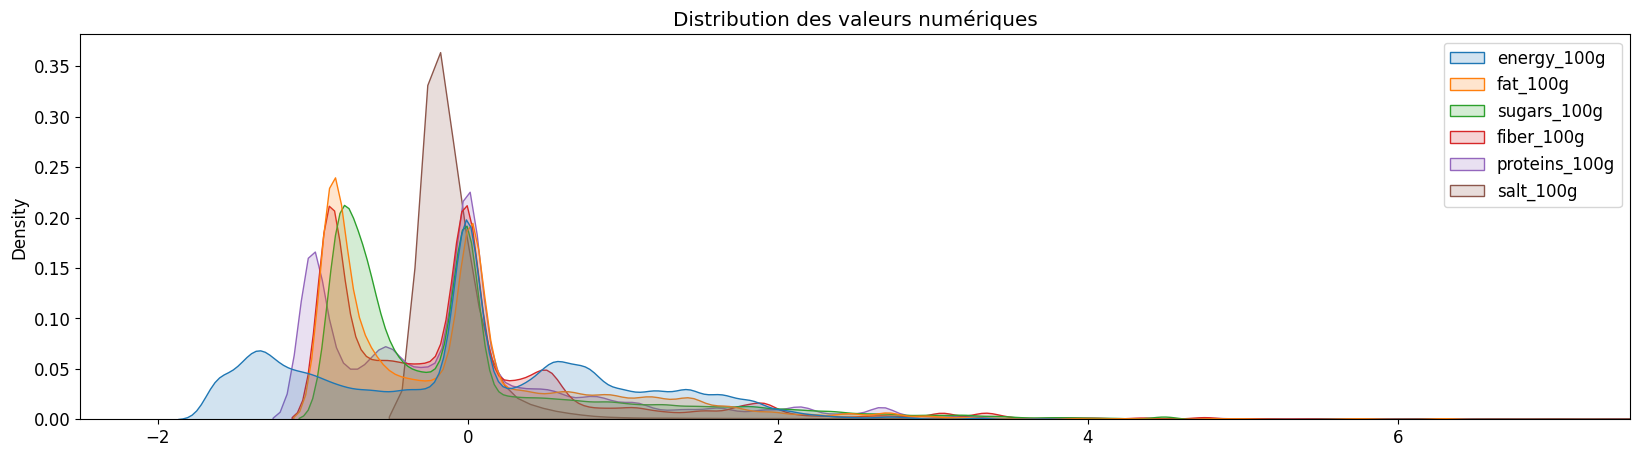

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))

sns.kdeplot(data=scaled_df[nutritive_values], fill=True, alpha=.2)
ax.set_title("Distribution des valeurs numériques")
ax.set_xlim(-2.5, 7.5)

plt.show()

Nous voyons donc que les valeurs de nos variables sont basses. Nous remarquons des pics assez homogènes autour des valeurs 0. Il est probable que ces pics sont dus à notre iterative imputer, qui aura tendance à distribuer nos données vers le centre.

Ensuite, regardons maintenant la distribution des nutriscores à l'aide d'un histogramme.

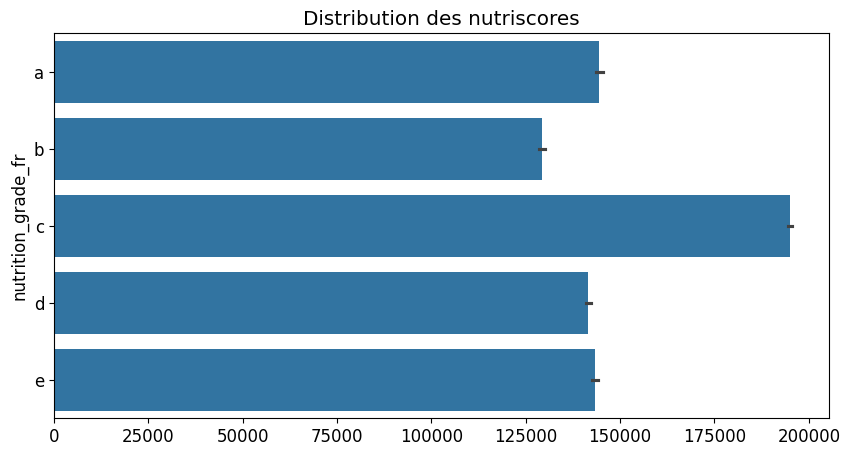

In [ ]:
df["nutrition_grade_fr"] = df["nutrition_grade_fr"].round(0)
df = df.replace({"nutrition_grade_fr": {0 : "a", 1 : "b", 2 : "c", 3 : "d", 4 : "e"}})
df['nutrition_grade_fr'] = pd.Categorical(df['nutrition_grade_fr'], ["a","b","c","d","e"])

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=df["nutrition_grade_fr"])
ax.set_title("Distribution des nutriscores")

plt.show()

Nous voyons que l'iterative imputer à légèrement changé notre distribution. Les données étaient plutôt concentrées vers "d", et maintenant elles le sont plutôt sur "c".

Pour finir avec cette étape, nous allons regarder la corrélation de nos variables avec la variable cible.

In [ ]:
correlation_table = scaled_df
correlation_table = pd.merge(correlation_table, pd.DataFrame(target), how="right", left_on="url", right_on="url")
correlation_table.dropna(inplace=True)

target_encoder = LabelEncoder()
nutrition_grade_encoder = LabelEncoder()
correlation_table.loc[:, "categories_fr"] = target_encoder.fit_transform(correlation_table["categories_fr"])
correlation_table.loc[:, "nutrition_grade_fr"] = nutrition_grade_encoder.fit_transform(correlation_table["nutrition_grade_fr"])

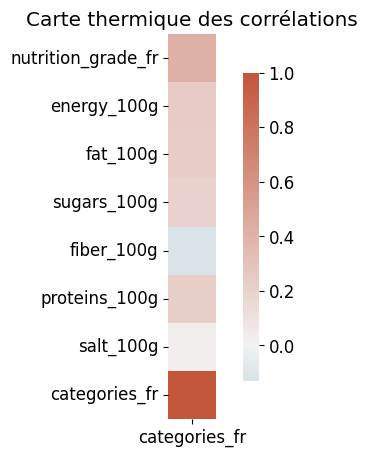

In [ ]:
corr_matrix = correlation_table.drop(columns=["url"]).corr()

f, ax = plt.subplots(figsize=(7, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix[["categories_fr"]], cmap=cmap, center=0, square=True, cbar_kws={"shrink": .8})
ax.set_title("Carte thermique des corrélations")

plt.show()

Nous remarquons une corrélation. Ceci montre que l'imputation de données dans notre variable cible devrait être cohérente.

## Étape 5 : Réalisez une analyse multi-variée

Nous allons maintenant réaliser une ACP.

In [ ]:
pca_scaler = StandardScaler()
pca_table = pca_scaler.fit_transform(correlation_table.drop(columns=["url"]))
pca_table = pd.DataFrame(pca_table)

n_components = 6
pca = PCA(n_components=n_components)
pca.fit(pca_table)

pca.explained_variance_ratio_

array([0.33375711, 0.17365808, 0.16080699, 0.1190339 , 0.10035561,
       0.06572988])

Voici ce que chaque dimension note ACP représente. Affichons maintenant un éboulis, afin de visualiser la représentation de nos variables pour chaque axe.

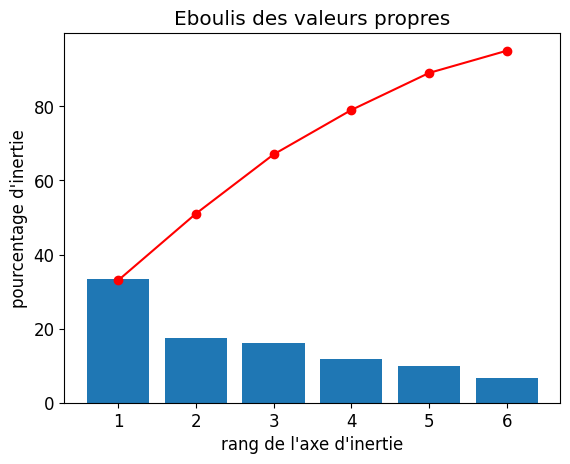

In [ ]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
x_list = range(1, n_components+1)

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Près de 80% de nos valeurs sont représentés dans les 4 premier axes.

Mettons en place une heatmap et un cercle afin de voir la corrélation des variables avec les axes de l'ACP.

<Axes: >

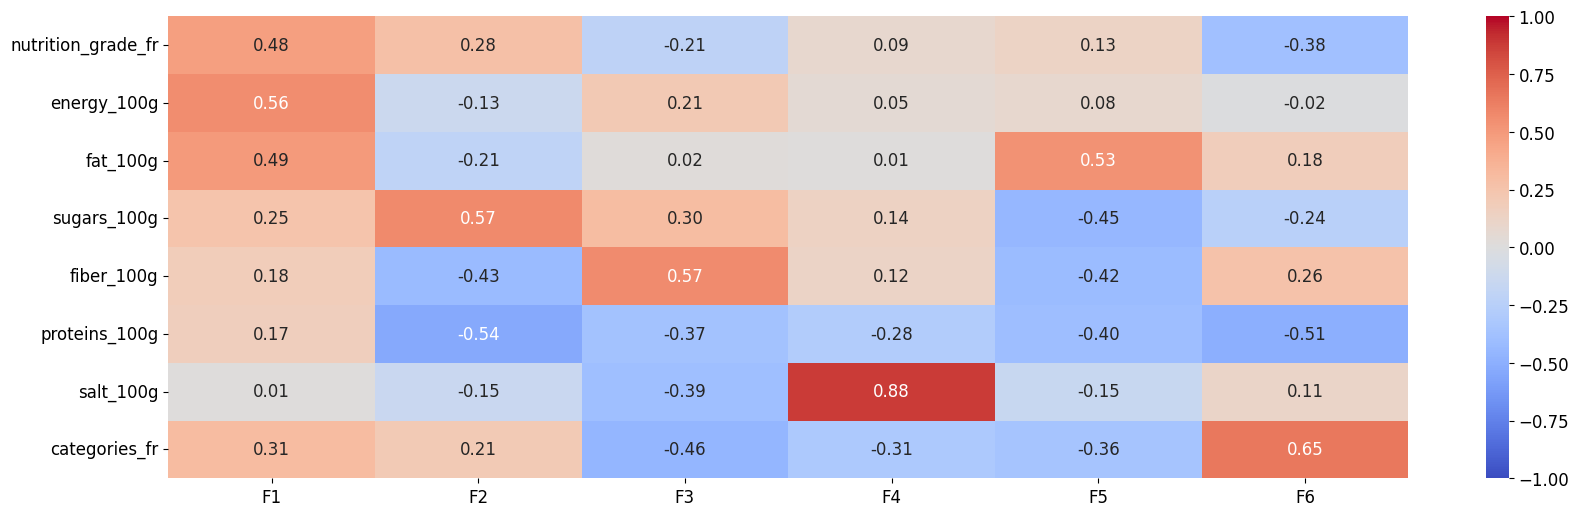

In [ ]:
features = correlation_table.drop(columns=["url"]).columns

pcs = pd.DataFrame(pca.components_)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]

fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

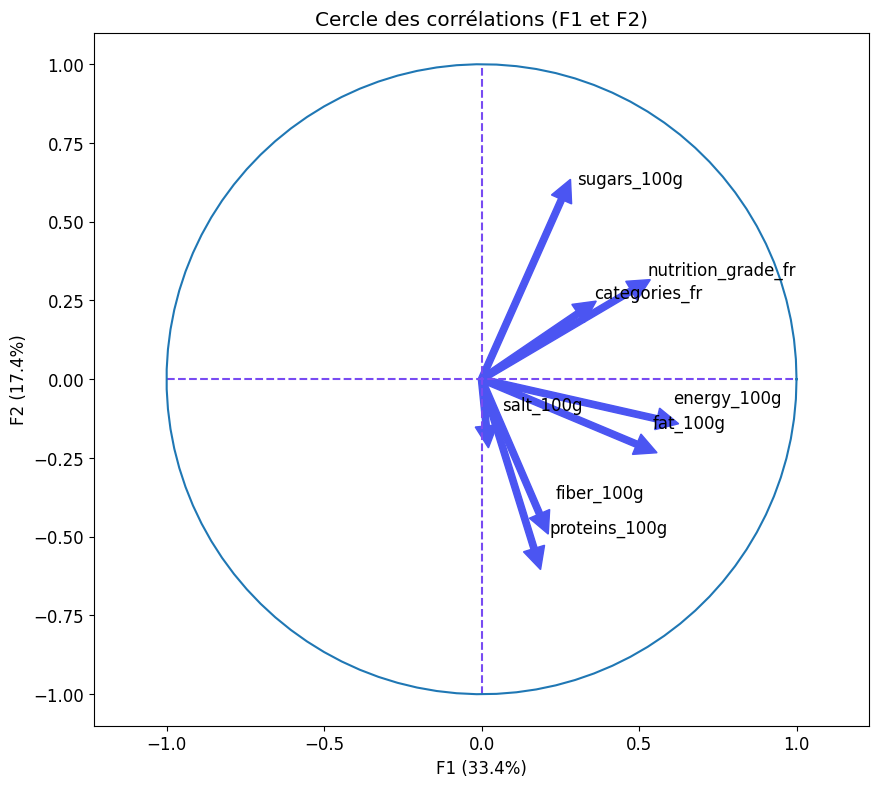

In [ ]:
fig, ax = plt.subplots(figsize=(10, 9))
x, y = 0, 1

for i in range(0, pca.components_.shape[1]):
    ax.arrow (
        0, 
        0,
        pca.components_[x, i],  
        pca.components_[y, i],  
        head_width=0.07,
        head_length=0.07, 
        width=0.02,
        color="#4B55F2"
    )
    plt.text (
        pca.components_[0, i] + 0.05,
        pca.components_[1, i] + 0.05,
        features[i]
    )

plt.plot([-1, 1], [0, 0], color='#784BF2', ls='--')
plt.plot([0, 0], [-1, 1], color='#784BF2', ls='--')

plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))

plt.axis('equal')
plt.show()

On remarque plusieurs variables assez corréllées. Par exemple "fiber_100g/proteins_100g", "energy_100g/fat_100g" ou bien encore "nutrition_grade_fr/categories_fr". Nous pourrions créer de nouvelles variables à partir de ces couples afin d'accélérer les étapes de machine learning de notre projet.

Nous pouvons maintenant réaliser une ANOVA afin d'étudier une corrélation dans la moyenne de nos variables.

In [ ]:
pca_table.columns = features
pca_table
f_oneway(pca_table["categories_fr"], pca_table["proteins_100g"])

F_onewayResult(statistic=np.float64(3.744095388312251e-28), pvalue=np.float64(1.0))

Nous ne remarquons pas de corrélation.